In [1]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.3 MB/s eta 0:00:00


# 🔴 **Import Libs**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from tqdm import tqdm
import re

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizerFast
from transformers import AutoModel, AutoConfig

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔴 **Arguments**

In [31]:
num_epochs = 10

lr = 2e-5
seed = 8

# 🔴 **Utils**


In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [6]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔴 **Dataset**

## 🟠 Load the Dataset

In [7]:
! cp /content/drive/MyDrive/sentiment_analysis/model_best.pt /content/

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [9]:
!kaggle datasets download -d soheiltehranipour/snappfood-persian-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/soheiltehranipour/snappfood-persian-sentiment-analysis
License(s): CC0-1.0
100% 3.16M/3.16M [00:01<00:00, 3.55MB/s]
100% 3.16M/3.16M [00:01<00:00, 2.68MB/s]


In [10]:
!unzip snappfood-persian-sentiment-analysis.zip

Archive:  snappfood-persian-sentiment-analysis.zip
  inflating: Snappfood - Sentiment Analysis.csv  


In [11]:
df = pd.read_csv("/content/Snappfood - Sentiment Analysis.csv" , on_bad_lines='skip' , delimiter='\t')

In [12]:
df.sample(5)

,Unnamed: 0,comment,label,label_id
30991,NaN,alii bood kheili khoshmaze va gheimatam ali bood,HAPPY,0.0
4351,NaN,مرغ سوخاری مثل همیشه عالی و درجه یک بود، پیتزا...,HAPPY,0.0
2299,NaN,واقعا من تغریبا هر هفته ۳ بار از پرپروک‌غذا می...,SAD,1.0
52438,NaN,گوشت ۲ تکه کوچک ریز بیشتر نداشت!,SAD,1.0
1090,NaN,غذا سر د بود.,HAPPY,0.0


## 🟠 EDA

In [13]:
none_count = df['Unnamed: 0'].isnull().sum()

other_count = len(df) - none_count
plot_df = pd.DataFrame({
    'Item': ['None', 'Other'],
    'Count': [none_count, other_count]
})

fig = px.bar(plot_df, x='Item', y='Count', title='Number of Unnamed: 0 Column None Items vs Other Items')
fig.show()

print(f"Number of None items: {none_count}")
print(f"Number of Other items: {other_count}")

Number of None items: 69480
Number of Other items: 520


In [14]:
mismatch_count = 0
total_count = len(df)

for index, row in df.iterrows():
  label_id = row['label_id']
  label = row['label']

  if label_id == 1.0 and label != 'SAD':
    mismatch_count += 1
  elif label_id == 0.0 and label != 'HAPPY':
    mismatch_count += 1

if total_count > 0:
  mismatch_percent = (mismatch_count / total_count) * 100
  print(f"Mismatch percentage: {mismatch_percent:.2f}%")
else:
  print("No data found in the DataFrame.")

Mismatch percentage: 0.00%


In [15]:
df['label'].value_counts()

,count
label,
HAPPY,34916
SAD,34564
1,436
0,84


In [16]:
label_counts = df['label'].value_counts()
fig = px.pie(
    values=label_counts.values,
    names=label_counts.index,
    title='Distribution of Labels',
    hole=0.3,
    color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    pull=[0.1 if count == label_counts.max() else 0 for count in label_counts] )

fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    width=900,
    height=600)

fig.show()

## 🟠 Pre-proccess

In [17]:
df = df[df['Unnamed: 0'].isnull()]
df = df.drop('Unnamed: 0', axis=1)

In [18]:
pattern = re.compile(r'[a-zA-Z]')
df['contains_english'] = df['comment'].apply(lambda x: bool(pattern.search(x)))
len(df[df['contains_english']])

362

In [19]:
df = df[df['contains_english'] == False]
df = df.drop('contains_english',axis=1)
df

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0
...,...,...,...
69995,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1.0
69996,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1.0
69997,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0.0
69998,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1.0


In [20]:
train_texts, temp_text, train_labels, temp_label = train_test_split(
    df['comment'].tolist(),
    df['label_id'].astype(int).tolist(),
    test_size=0.3,
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_text,
    temp_label,
    test_size=0.5,
    random_state=42
)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

Training set size: 48382
Validation set size: 10368
Test set size: 10368


In [21]:
tokenizer = BertTokenizerFast.from_pretrained("HooshvareLab/bert-fa-base-uncased")

def encode_and_pad(texts, tokenizer, max_length=128):
    encoding = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return encoding['input_ids'], encoding['attention_mask']

train_sequences, train_attention_mask = encode_and_pad(train_texts, tokenizer)
val_sequences, val_attention_mask = encode_and_pad(val_texts, tokenizer)
test_sequences, test_attention_mask = encode_and_pad(test_texts, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

## 🟠 Custom Dataset

In [22]:
class SentimentDataset(Dataset):
    def __init__(self, sequences, attention_mask, labels):
        self.sequences = sequences
        self.attention_mask = attention_mask
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.sequences[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [23]:
train_dataset = SentimentDataset(train_sequences, train_attention_mask, train_labels)
val_dataset = SentimentDataset(val_sequences, val_attention_mask, val_labels)
test_dataset = SentimentDataset(test_sequences, test_attention_mask, test_labels)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 🔴 **Model**

In [25]:
class PersianTransformerSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, n_heads=8, n_layers=4, hidden_dim=512, output_dim=2,
                 max_seq_length=128, dropout=0.2, pad_idx=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Parameter(torch.zeros(max_seq_length, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(embedding_dim)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, text, attention_mask=None):
        x = self.embedding(text) + self.pos_embedding[:text.size(1), :]
        x = self.layer_norm(x)

        if attention_mask is not None:
            attention_mask = attention_mask.float().masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0.0)

        transformer_output = self.transformer(x, src_key_padding_mask=attention_mask)
        pooled = transformer_output.mean(dim=1)

        x = self.fc1(pooled)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        output = self.fc3(x)
        return output

In [26]:
class PersianTransformerSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, n_heads=8, n_layers=4, hidden_dim=512, output_dim=2, max_seq_length=128, dropout=0.2, pad_idx=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Parameter(torch.zeros(max_seq_length, embedding_dim))

        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, text, attention_mask=None):
        x = self.embedding(text) + self.pos_embedding[:text.size(1), :]
        x = self.layer_norm(x)

        if attention_mask is not None:
            attention_mask = attention_mask.float().masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0.0)

        transformer_output = self.transformer(x, src_key_padding_mask=attention_mask)
        pooled = transformer_output.mean(dim=1)

        x = self.fc1(pooled)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        output = self.fc3(x)
        return output

# 🔴 **Train**

In [27]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metrics, scheduler=None, max_grad_norm=1.0):
    model.train()
    loss_train = AverageMeter()

    for metric in metrics.values():
        metric.reset()

    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            loss_train.update(loss.item(), n=targets.size(0))
            for metric_name, metric in metrics.items():
                metric.update(outputs, targets)

            tepoch.set_postfix(loss=loss_train.avg)

    final_metrics = {name: metric.compute().item() for name, metric in metrics.items()}

    if scheduler:
        scheduler.step(loss_train.avg)

    return loss_train.avg, final_metrics

# 🔴 **Evaluation**

In [28]:
def evaluate(model, test_loader, loss_fn, metrics):
    model.eval()
    loss_eval = AverageMeter()

    for metric in metrics.values():
        metric.reset()

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(inputs, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)

            loss_eval.update(loss.item(), n=targets.size(0))
            for metric_name, metric in metrics.items():
                metric.update(outputs, targets)

    final_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    return loss_eval.avg, final_metrics

# 🔴 **Config**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
set_seed(seed)

model = PersianTransformerSentiment(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=256,
    hidden_dim=512,
    output_dim=2,
    max_seq_length=128,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



PersianTransformerSentiment(
  (embedding): Embedding(100000, 256, padding_idx=0)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, 

In [33]:
set_seed(seed)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [34]:
metrics = {
    "accuracy": MulticlassAccuracy(num_classes=2).to(device),
    "precision": MulticlassPrecision(num_classes=2).to(device),
    "recall": MulticlassRecall(num_classes=2).to(device),
    "f1": MulticlassF1Score(num_classes=2).to(device),
}

# 🔴 **Training Process**

## 🟠 Main Loop

In [44]:
# for more epochs

# state_dict = torch.load("/content/model_best.pt", weights_only=True)
# model.load_state_dict(state_dict)
# model.to(device)

In [45]:
set_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [36]:
best_loss_valid = float('inf')
loss_train_hist, loss_valid_hist = [], []
metric_train_hist, metric_valid_hist = [], []

In [37]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}")
    train_loss, train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, metrics, scheduler
    )
    val_loss, val_metrics = evaluate(model, val_loader, criterion, metrics)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print("Train Metrics:", train_metrics)
    print("Validation Metrics:", val_metrics)

        # Logging metrics and loss
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(val_loss)
    metric_train_hist.append(train_metrics)
    metric_valid_hist.append(val_metrics)

    if val_loss < best_loss_valid:
      best_loss_valid = val_loss
      torch.save(model.state_dict(), "best_model.pt")
      print("Model saved!")

Epoch 1


100%|██████████| 3024/3024 [01:41<00:00, 29.93batch/s, loss=0.415]


Train Loss: 0.4149, Validation Loss: 0.4088
Train Metrics: {'accuracy': 0.8099667429924011, 'precision': 0.8122007250785828, 'recall': 0.8099667429924011, 'f1': 0.8094409704208374}
Validation Metrics: {'accuracy': 0.8243955373764038, 'precision': 0.8258132934570312, 'recall': 0.8243955373764038, 'f1': 0.8241776823997498}
Model saved!
Epoch 2


100%|██████████| 3024/3024 [01:38<00:00, 30.59batch/s, loss=0.358]


Train Loss: 0.3584, Validation Loss: 0.3518
Train Metrics: {'accuracy': 0.8441070914268494, 'precision': 0.8464616537094116, 'recall': 0.8441070914268494, 'f1': 0.8436534404754639}
Validation Metrics: {'accuracy': 0.8487130403518677, 'precision': 0.8529348373413086, 'recall': 0.8487130403518677, 'f1': 0.8483036756515503}
Model saved!
Epoch 3


100%|██████████| 3024/3024 [01:38<00:00, 30.68batch/s, loss=0.339]


Train Loss: 0.3390, Validation Loss: 0.3496
Train Metrics: {'accuracy': 0.8543339371681213, 'precision': 0.8566541075706482, 'recall': 0.8543339371681213, 'f1': 0.8539098501205444}
Validation Metrics: {'accuracy': 0.8509450554847717, 'precision': 0.8532635569572449, 'recall': 0.8509450554847717, 'f1': 0.8507329821586609}
Model saved!
Epoch 4


100%|██████████| 3024/3024 [01:39<00:00, 30.53batch/s, loss=0.325]


Train Loss: 0.3252, Validation Loss: 0.3442
Train Metrics: {'accuracy': 0.8621546626091003, 'precision': 0.864234209060669, 'recall': 0.8621546626091003, 'f1': 0.8617803454399109}
Validation Metrics: {'accuracy': 0.8530623316764832, 'precision': 0.8559881448745728, 'recall': 0.8530623316764832, 'f1': 0.852796733379364}
Model saved!
Epoch 5


100%|██████████| 3024/3024 [01:39<00:00, 30.53batch/s, loss=0.313]


Train Loss: 0.3131, Validation Loss: 0.3535
Train Metrics: {'accuracy': 0.8675885200500488, 'precision': 0.869650661945343, 'recall': 0.8675885200500488, 'f1': 0.8672270774841309}
Validation Metrics: {'accuracy': 0.8570196628570557, 'precision': 0.8595981597900391, 'recall': 0.8570196628570557, 'f1': 0.8567975759506226}
Epoch 6


100%|██████████| 3024/3024 [01:38<00:00, 30.61batch/s, loss=0.301]


Train Loss: 0.3014, Validation Loss: 0.3563
Train Metrics: {'accuracy': 0.875203013420105, 'precision': 0.8770378232002258, 'recall': 0.875203013420105, 'f1': 0.8748838901519775}
Validation Metrics: {'accuracy': 0.8517495393753052, 'precision': 0.8518062829971313, 'recall': 0.8517495393753052, 'f1': 0.8517484664916992}
Epoch 7


100%|██████████| 3024/3024 [01:38<00:00, 30.58batch/s, loss=0.29]


Train Loss: 0.2899, Validation Loss: 0.3545
Train Metrics: {'accuracy': 0.8811016082763672, 'precision': 0.8827037215232849, 'recall': 0.8811016082763672, 'f1': 0.8808201551437378}
Validation Metrics: {'accuracy': 0.8592450618743896, 'precision': 0.8610246181488037, 'recall': 0.8592450618743896, 'f1': 0.8591001033782959}
Epoch 8


100%|██████████| 3024/3024 [01:39<00:00, 30.54batch/s, loss=0.274]


Train Loss: 0.2745, Validation Loss: 0.4139
Train Metrics: {'accuracy': 0.8900788426399231, 'precision': 0.891450047492981, 'recall': 0.8900788426399231, 'f1': 0.8898364901542664}
Validation Metrics: {'accuracy': 0.8401176333427429, 'precision': 0.8416658639907837, 'recall': 0.8401176333427429, 'f1': 0.8399086594581604}
Epoch 9


100%|██████████| 3024/3024 [01:38<00:00, 30.58batch/s, loss=0.261]


Train Loss: 0.2615, Validation Loss: 0.4045
Train Metrics: {'accuracy': 0.8977227210998535, 'precision': 0.8986999988555908, 'recall': 0.8977227210998535, 'f1': 0.8975347280502319}
Validation Metrics: {'accuracy': 0.8503003120422363, 'precision': 0.8504127264022827, 'recall': 0.8503003120422363, 'f1': 0.8502953052520752}
Epoch 10


100%|██████████| 3024/3024 [01:38<00:00, 30.55batch/s, loss=0.247]


Train Loss: 0.2468, Validation Loss: 0.4048
Train Metrics: {'accuracy': 0.9058701992034912, 'precision': 0.9066155552864075, 'recall': 0.9058701992034912, 'f1': 0.9057160019874573}
Validation Metrics: {'accuracy': 0.851813793182373, 'precision': 0.8540606498718262, 'recall': 0.851813793182373, 'f1': 0.8516106605529785}


## 🟠 Plot

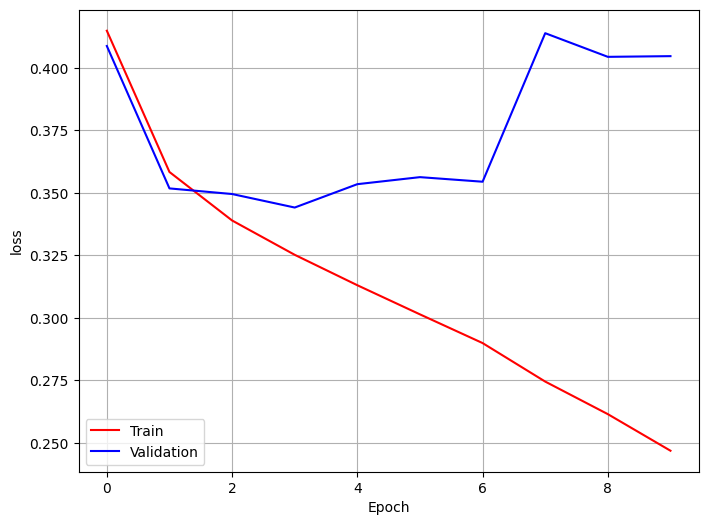

In [38]:
plt.figure(figsize=(8, 6))

plt.plot(loss_train_hist, 'r-', label='Train')
plt.plot(loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [39]:
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_metrics = evaluate(model, test_loader, criterion, metrics)
print(f"Test Loss: {test_loss:.4f}")
print("Test Metrics:", test_metrics)

<ipython-input-39-00c8a7138de9>:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss: 0.3622
Test Metrics: {'accuracy': 0.8476325869560242, 'precision': 0.850949764251709, 'recall': 0.8476325869560242, 'f1': 0.847000241279602}


# 🔴 **Generate**

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PersianTransformerSentiment(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=256,
    hidden_dim=512,
    output_dim=2,
    max_seq_length=128,
    pad_idx=tokenizer.pad_token_id
)

state_dict = torch.load("/content/model_best.pt")
model.load_state_dict(state_dict)
model.to(device)

<ipython-input-42-47d09527b3c0>:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



PersianTransformerSentiment(
  (embedding): Embedding(100000, 256, padding_idx=0)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, 

In [43]:
def generate_prediction(text, tokenizer, model, max_length=128):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_class = torch.argmax(outputs, dim=1).item()

    sentiment_map = {0: 'HAPPY', 1: 'SAD'}
    sentiment = sentiment_map.get(predicted_class, "Unknown")

    return sentiment

sample_texts = [
    "بسیار سرد بود",
    "پیتزا عالی و خوشمزه با کیفیت و به قیمت بود",
    "افتضاح بود بدتر از این امکان نداشت"
]

for text in sample_texts:
    sentiment = generate_prediction(text, tokenizer, model)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

Text: بسیار سرد بود
Predicted Sentiment: SAD

Text: پیتزا عالی و خوشمزه با کیفیت و به قیمت بود
Predicted Sentiment: HAPPY

Text: افتضاح بود بدتر از این امکان نداشت
Predicted Sentiment: SAD

